

# Plotting Results of X-ray Spectrum + Opt/UV SED fitting



This notebook will go over how to make some nice plots on the resulting best-fit model, and posteriors of the infered parameter





In [1]:
# We need interactive plotting for this one. If this does not work, try "matplotlib notebook" after the percentile symbol.
%matplotlib widget 

# General imports
import os
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import pandas as pd # we will need, install if you don't have yet
import corner # we will need, install if you don|'t have yet
import copy
import astropy.units as u

# Setting cosmology
cosmo = FlatLambdaCDM(H0=73, Om0=0.3, Tcmb0=2.725)

# Xspec, BXA, and UltraNest imports and config
from xspec import *
Xset.cosmo = "73"  # Cosmology for pyXPSEC
import bxa.xspec as bxa
bxa.BXASolver.allowed_stats.append("chi")  # Enable Gaussian statistics
from bxa.xspec.solver import set_parameters  # For later use
Fit.statMethod = "chi"  # Set pyXPSEC statistics to Gaussian
Fit.query = "yes"
Plot.device = "/xs"  # Plotting console for pyXPSEC
Plot.yLog = True
Plot.background = True
import ultranest
from ultranest.plot import PredictionBand # We will need this to plot the model posteriors

# Load diskSED model
from diskSED import diskSED_info, diskSED
AllModels.addPyMod(diskSED, diskSED_info(), 'add')  # Additive model

# Load reddenSF model (Calzetti et al. attenuation law)
from diskSED import reddenSF_info, reddenSF
AllModels.addPyMod(reddenSF, reddenSF_info(), 'mul')  # Multiplicative model

# Load reddenCCM model (CCM extinction law) This is the same as the XSPEC native 'redden' but extended to the Lyman limit.
from diskSED import reddenCCM_info, reddenCCM
AllModels.addPyMod(reddenCCM, reddenCCM_info(), 'mul')  # Multiplicative model

#Plotting configurations and imports
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams['font.size'] = 25
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['ytick.major.size']=   6
plt.rcParams['ytick.minor.size']=   3
plt.rcParams['xtick.major.size']=   6
plt.rcParams['xtick.minor.size']=   3#
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
from matplotlib import ticker

from matplotlib.ticker import (
#    LogFormatterMathtext,
 #   LogLocator,
    MaxNLocator,
    NullLocator,
   ## ScalarFormatter,
    AutoLocator
)

# Current working directory
cwd = os.getcwd()

Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.


# We will first plot the observed (no absorption/extinction corrections) and intrisic (all absorption/extinction corrections) spectral energy distrbituions. With some histograms for infered parameters.

In [2]:
# We need to load all the fitting steps/models/statistics again.
Xset.chatter = 1 # I don't want xspec output now.

# Source redshift
z = 0.0206

# Galactic color excess at 14li's position 
E_BV_G = 0.022

# Galactic column density at 14li's position (units of 10^22)
N_H_G = 1.95E+20 / 1e22

# Quick cleaning (in case something has been loaded already)
AllData.clear()
AllModels.clear()
AllData.clear()

Plot.xAxis = "keV"
# Set energy bins for the model (working from 5e-4 keV to 2 keV with 400 log bins)
AllModels.setEnergies('0.0005 2.0 400 log')

# Load X-ray and UV/optical data
E_lim = [0.25, 0.9]  # Energy limits for X-ray spectrum, use wathever criteria you think is resonable
os.chdir(os.path.join(cwd, 'data', 'SED'))
x_ray_file = '14li_E1_grp.fits'
uvopt_file = 'uvopt.pha'
AllData('1:1 ' + str(x_ray_file) + ' 1:2 ' + str(uvopt_file))

# Ignore bad channels
Xray = AllData(1)
Xray.response.arf = '14li_E1_arf.fits' # Sometimes we need to add the arf manually, it fails to find automatically.
Xray.ignore('0.0-' + str(E_lim[0]) + ' ' + str(E_lim[1]) + '-**')
uvopt = AllData(2)
uvopt.response = 'uvopt.rmf'
AllData.ignore("bad")

# Set the model
m = Model('phabs*redden*zashift*phabs*reddenSF*(diskSED)') 

# Let's edit these parameters, fix what needs to be fixed, and add reasonable ranges to those that will be fitted.

# phabs Nh
AllModels(1)(1).values = (N_H_G, -1)  # Fixing
# reddenCCM
AllModels(1)(2).values = (E_BV_G, -1) # This assumes a Galactic Gas-to-dust Ratio with R_v  = 3.1. See comments below. 
# zashift Redshift
AllModels(1)(3).values = (z, -1)  # Fixing
# phabs Nh
AllModels(1)(4).values = (0.04, 0.001, 0.00, 0.00, 0.1, 0.1)  # Change the mimimum to 0, we will need it to plot the intrisic SED.

# redden
AllModels(1)(5).link = '4 * 1e22 / 8.9505e21'  

# diskSED R_in*: Expected range for the Rin* parameter in km.
AllModels(1)(6).values = (3e7, 10, 3e7, 3e7, 1e8, 1e8)
# diskSED T_p: Expected range for inner disk temperature in Kelvin.
AllModels(1)(7).values = (2e5, 1e-2, 1e5, 1e5, 1e6, 1e6)
# diskSED R_ratio: Expected outer-to-inner radius ratio range.
AllModels(1)(8).values = (10, 1e-1, 5, 5, 30, 30)
# diskSED Distance: Distance to the source in Mpc. Needs to be fixed.
AllModels(1)(9).values = (cosmo.luminosity_distance(z).to('Mpc').value, -1)
# diskSED norm: This must always be set to 1.
AllModels(1)(10).values = (1, -1)  
# Rin* is already the normalization parameter of the model.

# These creates the priors
prior_NH = bxa.create_uniform_prior_for(AllModels(1), AllModels(1)(4)) # The number 1 is the data group (here we only have 1), while the other number is the paramter order, e.g. 4, see above. See BXA tutorial for details.
prior_R = bxa.create_loguniform_prior_for(AllModels(1), AllModels(1)(6))
prior_T = bxa.create_uniform_prior_for(AllModels(1), AllModels(1)(7))
prior_R_ratio = bxa.create_uniform_prior_for(AllModels(1), AllModels(1)(8))

# This creates all the rest
solver = bxa.BXASolver(transformations=[prior_NH, prior_R, prior_T, prior_R_ratio])

# Define/load here
paramnames_bxa = solver.paramnames
prior_bxa  = solver.prior_function
loglike_bxa  = solver.log_likelihood
prior_transform_bxa = solver.transformations

  uniform prior for nH between 0.000000 and 0.100000 
  jeffreys prior for R_in* between 3.000000e+07 and 1.000000e+08 
  uniform prior for T_p between 100000.000000 and 1000000.000000 
  uniform prior for R_ratio between 5.000000 and 30.000000 


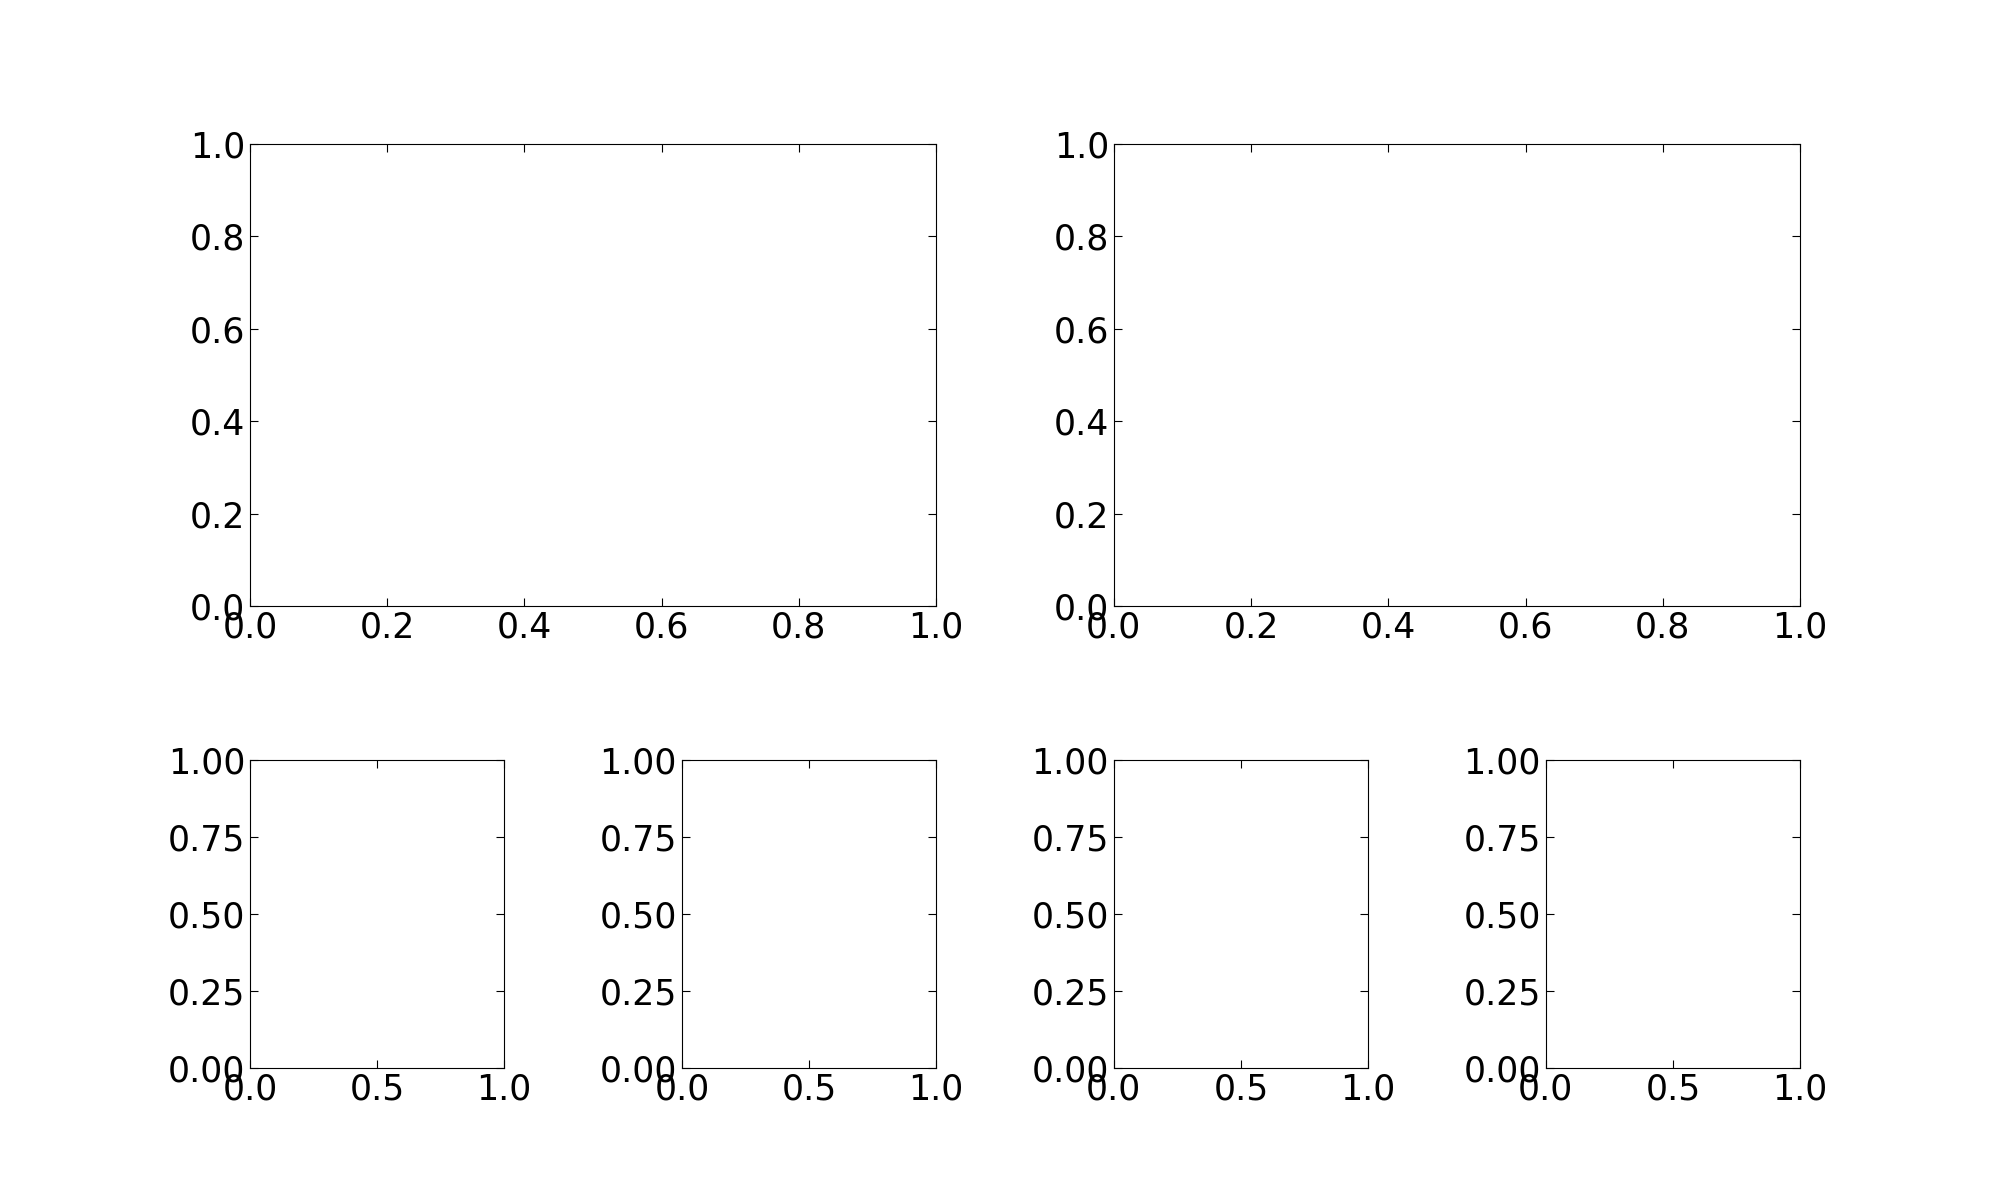

In [3]:
# Initilazing the plot
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(6, 4, figure=fig, wspace=0.7, hspace=0.0)

# Two panels for SEDs
ax_obs_sed = fig.add_subplot(gs[:3 , :2  ]) 
ax_int_sed = fig.add_subplot(gs[:3, 2:])

# Four panels for the four free parameters
ax_p1 = fig.add_subplot(gs[4:, 0])
ax_p2 = fig.add_subplot(gs[4:, 1])
ax_p3 = fig.add_subplot(gs[4:, 2])
ax_p4 = fig.add_subplot(gs[4:, 3])
axs_hist = [ax_p1,ax_p2,ax_p3,ax_p4]

In [4]:
# Plotting the parameters histogram

# Reading posterior
outputfiles_basename = 'diskSED_run'
results = pd.read_csv(os.path.join(cwd, 'data', "%s/posterior.csv" %(outputfiles_basename))) 
results_plots = copy.deepcopy(results) # just creating a copy for the histograms

results_plots.values[:, 0] = np.log10(1e22*(results.values[:, 0] )) #going from Nh/1e22 to log(N_h), just because look beter
results_plots.values[:, 2] = np.log10(results_plots.values[:, 2]) #going from Tp to log(Tp) 
#print(results_plots) #You can print to see what is what

def get_range(posterior):
    dim = np.shape(posterior)[1]
    ranges = []
    for i in range(dim):
        med, std = np.median(posterior[:, i]), np.std(posterior[:, i])
        ranges.append((med - 5*std, med + 5*std))
    return ranges

# Some properties/configurations 
dim = np.shape(results_plots)[1]
n_bins_1d = 25
quantiles = [0.5]
color='gold'
title_fmt = [".1f",".1f",".1f",".0f"]
xlabels = [ r"$\rm{log}$ $N_{\rm H} \ [\rm{cm^{-2}}]$",
        r"$\rm{log}$ $R_{\rm in}^{*}\  [\rm{km}]$",
        r"${\rm log} \ T_{\rm p} \ [\rm{K}]$",
       r"$R_{\rm out}/R_{\rm in}$"  
]
scale = ['linear', 'linear', 'linear', 'linear']
ranges = get_range(results_plots.values)

for i in range(dim):
        
        ax = axs_hist[i ]
        x = results_plots.values[:,  i]
        if scale[i] == "linear":
            bins_1d = np.linspace(min(ranges[i]), max(ranges[i]), n_bins_1d + 1)
        n, _, _ = ax.hist(x, bins=bins_1d, color=color, histtype='step', lw=2)
    
        qvalues = corner.quantile(x, quantiles)
        for q in qvalues:
            ax.axvline(q, ls="--", color=color, lw=2)
    
        ax.yaxis.set_major_locator(NullLocator())
    
        if scale[i] == "linear":
            ax.xaxis.set_major_locator(AutoLocator()) # You can go fancy with the locators and sticks here, as you wish!
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:" + title_fmt[i] + '}'))
        ax.tick_params(axis='both', which='major', labelsize=22)
        ax.set_xlabel(xlabels[i])
        ax.set_xlim(min(ranges[i]), max(ranges[i]))


In [5]:
# Plotting observed SED.

# --- Model Setup ---
Plot.xAxis = "Hz"
Plot("eemodel")
ax = ax_obs_sed
E_model = np.array(Plot.x(1))
spec_df1 = pd.DataFrame({"E_keV": E_model})

# --- Generate Model Posterior (First 100 samples for efficiency) --- There is not problem in using just the first 100 samples, because the posterior of nested sampling is random, i.e. it is not ordered, like in MCMC. You can increase to be more conservative, but this will increase the running time.
for i, row in results.head(100).iterrows():
    set_parameters(transformations=solver.transformations, values=row.values)
    Plot("eemodel")
    spec_df1[f"m_{i}"] = np.array(Plot.model(1))

# --- Median Posterior Model ---
median_posterior = np.median(results, axis=0)
set_parameters(transformations=solver.transformations, values=median_posterior[:100])
Plot("eemodel")
f_model = np.array(Plot.model(1))
E_model = np.array(Plot.x(1))

# --- X-ray Data Plot ---
Plot("eeufspec")
E_x, E_x_err = np.array(Plot.x(1)), np.array(Plot.xErr(1))
f_x, f_x_err = np.array(Plot.y(1)), np.array(Plot.yErr(1))

ax.errorbar(E_x, f_x, xerr=E_x_err, yerr=f_x_err, ls='', fmt='o',
            color='gold', markersize=8, elinewidth=2.5, 
            markeredgecolor='black', capsize=5, label='X-ray')

# --- Optical/UV Data Plot ---
E_uvop, E_uvop_err = np.array(Plot.x(2)), np.array(Plot.xErr(2))
f_uvop, f_uvop_err = np.array(Plot.y(2)), np.array(Plot.yErr(2))

ax.errorbar(E_uvop, f_uvop, xerr=E_uvop_err, yerr=f_uvop_err, fmt='d', 
            color='gold', markeredgecolor='black', markeredgewidth=1.0, 
            markersize=8, ecolor='gold', capsize=5, zorder=3, elinewidth=2.5)

# --- Axes Configuration ---
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(5e-15, 5e-11)
ax.set_xlim(9e13, 3e17)

# --- Prediction Band for Model Uncertainty ---
band = PredictionBand(spec_df1["E_keV"].values)
for column in spec_df1.filter(like='m_').iloc[:, :100]:
    band.add(spec_df1[column].values)

band.shade(ax=ax, color="gold", alpha=0.5, q=0.34, zorder=1) # q here is half of the percentile of the posteiror you want to be plotted, i.e. q=0.34 is %68 of the posterior.

# --- Labels and Formatting ---
ax.set_ylabel(r'$\nu F_{\nu}$ [erg cm$^{-2}$ s$^{-1}$]', fontsize=30)
ax.set_xlabel(r'$\nu_{\rm Obs}$ [$\rm Hz$]', fontsize=22, labelpad=10)
ax.tick_params(axis='both', which='major', pad=10)

# --- Secondary X-axis (Energy in keV) ---
E = lambda nu: (nu * u.Hz).to('keV', equivalencies=u.spectral()).value
xmin, xmax = ax.get_xlim()

ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_xlim((E(xmin), E(xmax)))
ax2.plot([], [])
ax2.set_xticks(np.flip([1, 0.1, 0.01, 0.001]))
ax2.set_xticklabels(np.flip([1, 0.1, 0.01, 0.001]))
ax2.set_xlabel(r'$E_{\rm Obs}$ [keV]', fontsize=22, labelpad=10)

/var/folders/hv/l8n0xl654pn93nm5rs3yyvnh0000gn/T/ipykernel_24473/148740543.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  spec_df1[f"m_{i}"] = np.array(Plot.model(1))


Text(0.5, 0, '$E_{\\rm Obs}$ [keV]')

In [6]:
# Plotting intrinsic SED.

# --- Initialize Plot and Model Setup ---
Plot.xAxis = "Hz"

# We need the intrisic model, so setting every absorption/extinction and redshift to zero.
AllModels(1)(1).values = 0.0
AllModels(1)(2).values = 0.0
AllModels(1)(3).values = 0.0
AllModels(1)(4).values = 0.0
AllModels(1)(5).values = 0.0
Plot("eemodel")
ax = ax_int_sed

# Energy Model Grid
E_model = np.array(Plot.x(1))
spec_df1 = pd.DataFrame({"E_keV": E_model})

# --- Generate Model Posterior (First 100 Samples Only) ---
for i, row in results.head(100).iterrows():
    set_parameters(transformations=solver.transformations, values=row.values)
    AllModels(1)(1).values = 0.0
    AllModels(1)(2).values = 0.0
    AllModels(1)(3).values = 0.0
    AllModels(1)(4).values = 0.0
    AllModels(1)(5).values = 0.0
    Plot("eemodel")
    spec_df1[f"m_{i}"] = np.array(Plot.model(1))

# --- Median Posterior Model ---
median_posterior = np.median(results, axis=0)
set_parameters(transformations=solver.transformations, values=median_posterior[:100])
#Getting back to real values
AllModels(1)(1).values = (N_H_G, -1)
AllModels(1)(2).values = (E_BV_G, -1)  # Galactic Gas-to-Dust Ratio
AllModels(1)(3).values = z
AllModels(1)(4).values = median_posterior[0]
AllModels(1)(5).link = '4 * 1e22 / 8.9505e21'  # Galactic Gas-to-Dust Ratio

# Scaling Factor
D_cm = cosmo.luminosity_distance(z).to('cm')
scale = 4 * np.pi * D_cm**2

# --- Plot X-ray Data ---
Plot("eeufspec chi")
E_x, E_x_err = np.array(Plot.x(1)), np.array(Plot.xErr(1))
f_x, f_x_err = np.array(Plot.y(1)), np.array(Plot.yErr(1))
f_x_model_tb = np.array(Plot.model(1))

# --- Plot Optical/UV Data ---
E_uvop, E_uvop_err = np.array(Plot.x(2)), np.array(Plot.xErr(2))
f_uvop, f_uvop_err = np.array(Plot.y(2)), np.array(Plot.yErr(2))
f_opt_model_tb = np.array(Plot.model(2))

# --- Plot Model Spectrum ---
AllModels(1)(1).values = 0
AllModels(1)(2).values = 0
AllModels(1)(3).values = 0
AllModels(1)(4).values = 0
AllModels(1)(5).values = 0
Plot("eemodel")
f_model = np.array(Plot.model(1))
E_model = np.array(Plot.x(1))

# --- Plot X-ray with Scaling ---
Plot("eeufspec")
E_x = np.array(Plot.x(1))
f_x_model = np.array(Plot.model(1))
xratio = f_x_model / f_x_model_tb # Absorption correction factor
ax.errorbar(E_x, f_x * xratio * scale, xerr=E_x_err, yerr=f_x_err * xratio * scale,
            ls='', fmt='o', color='gold', markersize=8, elinewidth=2.5,
            markeredgecolor='black', capsize=5)

# --- Plot Optical/UV with Scaling ---
E_uvop = np.array(Plot.x(2))
f_opt_model = np.array(Plot.model(2))
opt_ratio = f_opt_model / f_opt_model_tb # Extinction correction
ax.errorbar(E_uvop, f_uvop * opt_ratio * scale, xerr=E_uvop_err, yerr=f_uvop_err * opt_ratio * scale,
            fmt='d', color='gold', markeredgecolor='black', markeredgewidth=1.0,
            markersize=8, ecolor='gold', capsize=5, zorder=3, elinewidth=2.5)

# --- Axes Configuration ---
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e40, 1e45)
ax.set_xlim(9e13, 3e17)

# --- Prediction Band for Model Uncertainty ---
band = PredictionBand(spec_df1["E_keV"].values)
for column in spec_df1.filter(like='m_').iloc[:, :100]:
    band.add(spec_df1[column].values * scale)

band.shade(ax=ax, color="gold", alpha=0.5, q=0.34)

# --- Labels and Tick Configuration ---
ax.set_ylabel(r'$\nu L_{\nu}$ [erg s$^{-1}$]', fontsize=30)
ax.set_xlabel(r'$\nu_{\rm rest}$ [$\rm Hz$]', fontsize=22, labelpad=10)
ax.tick_params(axis='both', which='major', pad=10)

# --- Secondary X-axis (Energy in keV) ---
E = lambda nu: (nu * u.Hz).to('keV', equivalencies=u.spectral()).value
xmin, xmax = ax.get_xlim()

ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_xlim((E(xmin), E(xmax)))
ax2.plot([], [])
ax2.set_xticks(np.flip([1, 0.1, 0.01, 0.001]))
ax2.set_xticklabels(np.flip([1, 0.1, 0.01, 0.001]))
ax2.set_xlabel(r'$E_{\rm rest}$ [keV]', fontsize=22, labelpad=10)

/var/folders/hv/l8n0xl654pn93nm5rs3yyvnh0000gn/T/ipykernel_24473/2858830226.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  spec_df1[f"m_{i}"] = np.array(Plot.model(1))


Text(0.5, 0, '$E_{\\rm rest}$ [keV]')

# Creating a Corner Plot for the Parameters

Standard corner plots can often look plain and boring. Let's add some vibrant colors and stylish design to make them more engaging and visually appealing!

Some advanced usage of corner plots (which includes different colors, and superimpose parameters) can be seen in e.g.:

https://arxiv.org/abs/2408.17296
and 
https://arxiv.org/abs/2408.17296

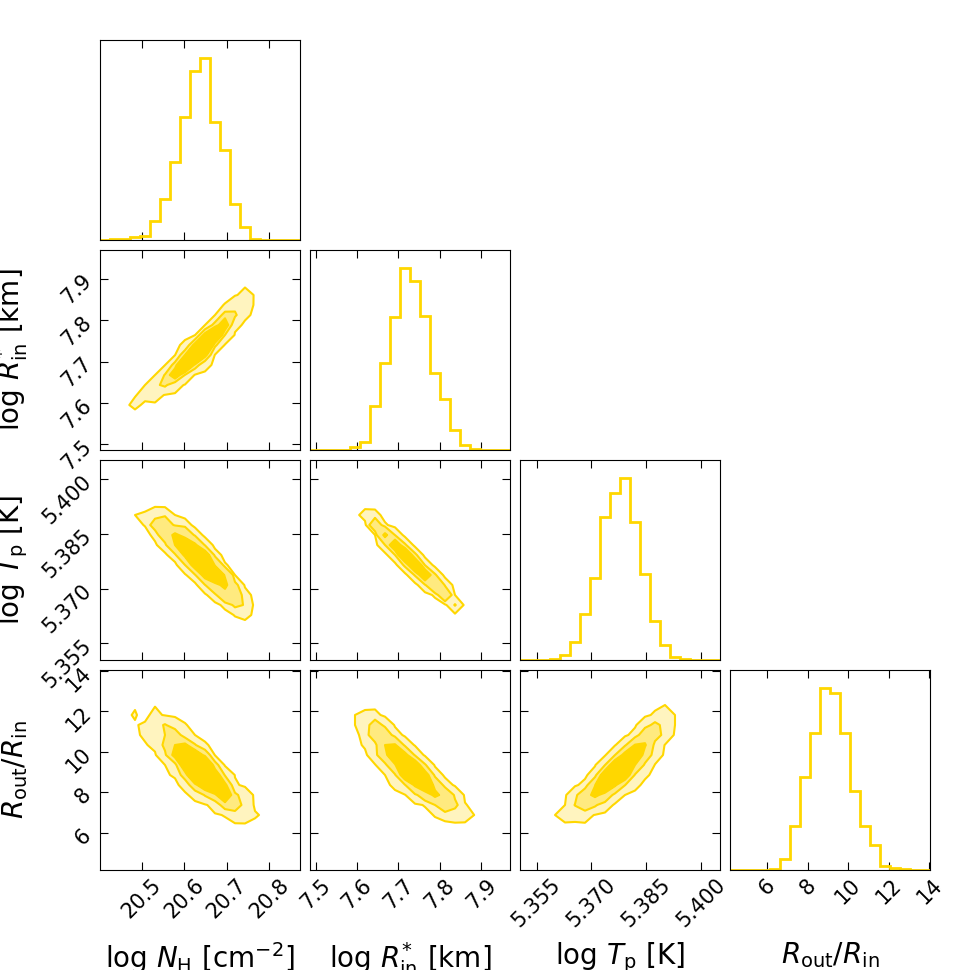

In [7]:
outputfiles_basename = 'diskSED_run'
results = pd.read_csv(os.path.join(cwd, 'data', "%s/posterior.csv" %(outputfiles_basename))) 
results_plots = copy.deepcopy(results) # just creating a copy for the histograms


results_plots.values[:, 0] = np.log10(1e22*(results.values[:, 0] )) #going from Nh/1e22 to log(N_h), just because look beter
results_plots.values[:, 2] = np.log10(results_plots.values[:, 2]) #going from Tp to log(Tp) 
#print(results_plots) #You can print to see what is what

ranges = get_range(results_plots.values)
plt.rcParams['font.size'] = 15
fig = corner.corner(
    results_plots.values,
    labels=[
       r"$\rm{log}$ $N_{\rm H} \ [\rm{cm^{-2}}]$",
        r"$\rm{log}$ $R_{\rm in}^{*}\  [\rm{km}]$",
        r"${\rm log} \ T_{\rm p} \ [\rm{K}]$",
       r"$R_{\rm out}/R_{\rm in}$"  
    ],
    
    show_titles=False,
    title_kwargs={"fontsize": 15},
    labelpad = 0.05,
    label_kwargs={"fontsize": 20},
    range =  ranges,
     fill_contours=True, levels=[0.68, 0.9, 0.99], plot_datapoints=False,
    color='gold', hist_kwargs={'lw':2}, 
)